In [2]:
%reload_ext autoreload 

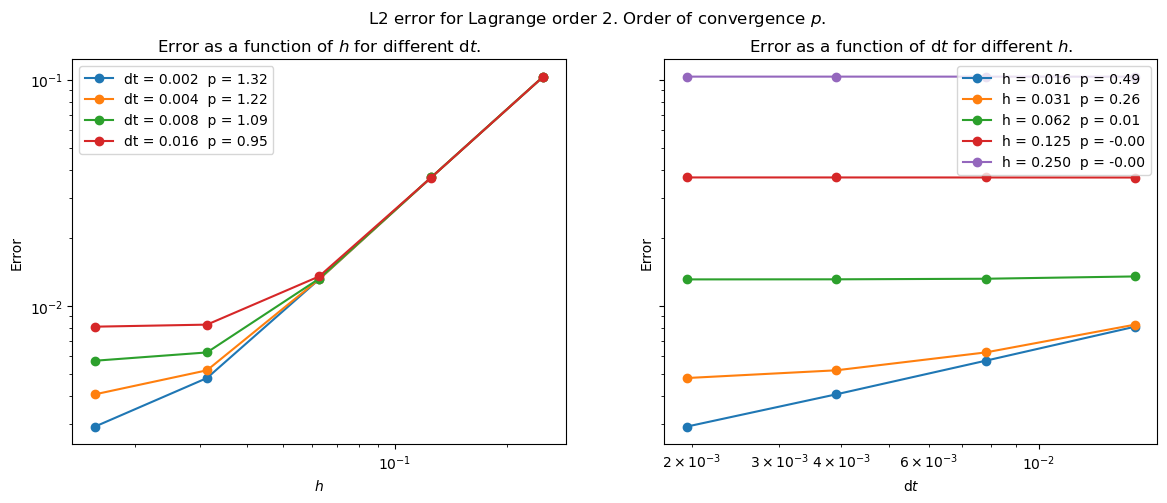

In [11]:
%autoreload
import op_splitting as op 
op.analyse_error(5, 4, startSpatial=1, startTemporal=5, theta=0.5, lagrangeOrder=2)

In [16]:
%autoreload
op.solve(0.1,0.01, 0.5,1,"mondomain.xdmf")

(Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 144), Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, [])), 720),
 SpatialCoordinate(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 144)),
 Constant(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False, float64, []), (2,)), 144), (), 144))